In [31]:
import os
import re
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import librosa
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data Collection and Inspection

In [2]:
#loading validated records data
data_path = 'en/validated.tsv'

validated = pd.read_csv(data_path, sep='\t')

validated.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0432ddcb259937fdea308281cf359701843b7e45cb068b...,common_voice_en_38400274.mp3,The bow was towed to the Marghera shipyard whe...,4,0,NaN,NaN,"polish,Slavic,Foreign,Easter European",NaN,en,NaN
1,074d49c2d50d4d49f4a380888b24d824b09f4bc046edc8...,common_voice_en_38229408.mp3,The black-and-white video depicts a sad Shakir...,2,0,NaN,NaN,NaN,NaN,en,NaN
2,0c3cfe9c1348466c4c418eba79a794ae6b85f242c234ed...,common_voice_en_38029302.mp3,Also at Allen Park is the relocated Tom Collin...,2,0,NaN,NaN,NaN,NaN,en,NaN
3,0d4af81e1ef834b86153f6f3e1f86bc2450488cbcdc3bf...,common_voice_en_38096117.mp3,They subsequently formed an oppositional group...,2,0,twenties,female,"India and South Asia (India, Pakistan, Sri Lanka)",NaN,en,NaN
4,0dbd9404fe8c3d057dfc6091eb7a8b2f1218d9814d38c7...,common_voice_en_38057509.mp3,"Today, corporate-run prisons hold eight percen...",2,0,NaN,NaN,"United States English,Californian",NaN,en,NaN


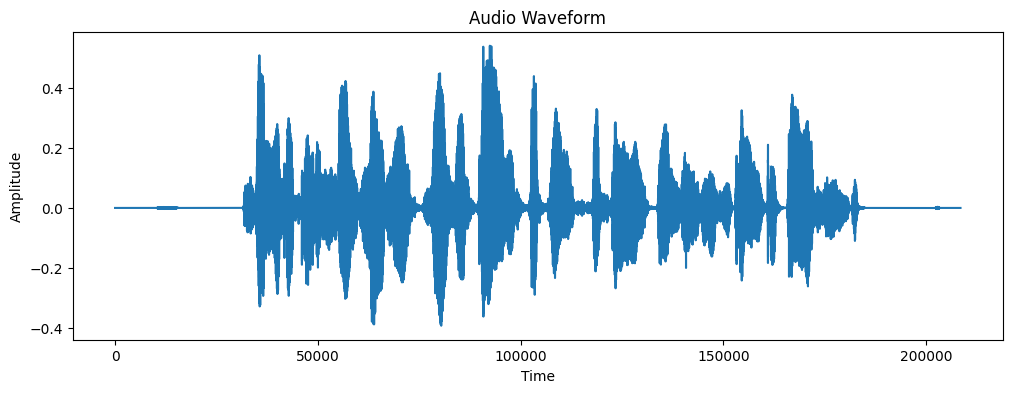

In [3]:
#loading audio sample, graph of the audio
audio_path = 'en/clips/'

sample_audio = audio_path + validated.iloc[10]['path']
audio, sr = librosa.load(sample_audio, sr=None)

plt.figure(figsize=(12, 4))
plt.plot(audio)
plt.title('Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [4]:
#dataset shape check
validated.shape

(3066, 11)

In [5]:
#dataset info (datatypes)
validated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   3066 non-null   object 
 1   path        3066 non-null   object 
 2   sentence    3066 non-null   object 
 3   up_votes    3066 non-null   int64  
 4   down_votes  3066 non-null   int64  
 5   age         2937 non-null   object 
 6   gender      2937 non-null   object 
 7   accents     2908 non-null   object 
 8   variant     0 non-null      float64
 9   locale      3066 non-null   object 
 10  segment     0 non-null      float64
dtypes: float64(2), int64(2), object(7)
memory usage: 263.6+ KB


# Data Cleaning

In [6]:
#checking for NA values
validated.isna().sum()

client_id        0
path             0
sentence         0
up_votes         0
down_votes       0
age            129
gender         129
accents        158
variant       3066
locale           0
segment       3066
dtype: int64

In [7]:
#dropping the columns with no data (only NA)
validated = validated.drop(columns=['variant', 'segment'])

In [8]:
#dropping the data (rows) with NA value
validated_cleaned = validated.dropna().reset_index(drop=True)

validated_cleaned.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,0d4af81e1ef834b86153f6f3e1f86bc2450488cbcdc3bf...,common_voice_en_38096117.mp3,They subsequently formed an oppositional group...,2,0,twenties,female,"India and South Asia (India, Pakistan, Sri Lanka)",en
1,125a681f7f7da191438ee50c0ce46046faaa4f8257cc44...,common_voice_en_38334309.mp3,"Herbal preparations are regulated as foods, ra...",4,0,thirties,other,"United States English,England English,Transatl...",en
2,38baffdc4f8c4f6c072f745d8c80bf45ffeedf0317d94e...,common_voice_en_38281099.mp3,The transgressions become fastened to persons ...,2,1,fourties,male,United States English,en
3,39644ad461ba8d697f0a7abb1c586cedab5735c7b692a3...,common_voice_en_38405020.mp3,"He is interred at Evergreen Cemetery, New Have...",3,0,teens,male,"Australian English,Canadian English",en
4,41e95a653757e741f4cd5ee43216baa82fdbb2b03d901e...,common_voice_en_38160769.mp3,Pickerel and were transferred and commissioned...,2,0,fourties,male,United States English,en


In [9]:
#dataset shape check
validated_cleaned.shape

(2819, 9)

In [10]:
#checking for NA values
validated_cleaned.isna().sum()

client_id     0
path          0
sentence      0
up_votes      0
down_votes    0
age           0
gender        0
accents       0
locale        0
dtype: int64

In [11]:
#normalization function
def normalize_text(text):
    #converting into lowercase
    text = text.lower()
    
    #removing special characters
    text = re.sub(r'[^a-z0-9\s,.]', '', text)
    
    #removing the whitespaces from the beginning and end
    text = text.strip()
    
    #replacing multiple doublespaces with one
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [12]:
#applying normalization
validated_cleaned.loc[:, 'sentence'] = validated_cleaned['sentence'].apply(normalize_text)

validated_cleaned.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale
0,0d4af81e1ef834b86153f6f3e1f86bc2450488cbcdc3bf...,common_voice_en_38096117.mp3,they subsequently formed an oppositional group...,2,0,twenties,female,"India and South Asia (India, Pakistan, Sri Lanka)",en
1,125a681f7f7da191438ee50c0ce46046faaa4f8257cc44...,common_voice_en_38334309.mp3,"herbal preparations are regulated as foods, ra...",4,0,thirties,other,"United States English,England English,Transatl...",en
2,38baffdc4f8c4f6c072f745d8c80bf45ffeedf0317d94e...,common_voice_en_38281099.mp3,the transgressions become fastened to persons ...,2,1,fourties,male,United States English,en
3,39644ad461ba8d697f0a7abb1c586cedab5735c7b692a3...,common_voice_en_38405020.mp3,"he is interred at evergreen cemetery, new have...",3,0,teens,male,"Australian English,Canadian English",en
4,41e95a653757e741f4cd5ee43216baa82fdbb2b03d901e...,common_voice_en_38160769.mp3,pickerel and were transferred and commissioned...,2,0,fourties,male,United States English,en


# Exploratory Data Analysis (EDA)

In [13]:
#loading clip_durations table
clip_durations_path = 'en/clip_durations.tsv'
clip_durations = pd.read_csv(clip_durations_path, sep='\t')

clip_durations.head()

,clip,duration[ms]
0,common_voice_en_24767295.mp3,2844
1,common_voice_en_36313116.mp3,5112
2,common_voice_en_24389233.mp3,7668
3,common_voice_en_139641.mp3,4992
4,common_voice_en_544777.mp3,4560


In [14]:
#merging tables
validated_cleaned.rename(columns={'path': 'clip'}, inplace=True)

validated_cleaned = validated_cleaned.merge(clip_durations, on='clip', how='left')

In [15]:
#renaming column
validated_cleaned.rename(columns={'duration[ms]': 'audio_length'}, inplace=True)

validated_cleaned.head()

,client_id,clip,sentence,up_votes,down_votes,age,gender,accents,locale,audio_length
0,0d4af81e1ef834b86153f6f3e1f86bc2450488cbcdc3bf...,common_voice_en_38096117.mp3,they subsequently formed an oppositional group...,2,0,twenties,female,"India and South Asia (India, Pakistan, Sri Lanka)",en,10008
1,125a681f7f7da191438ee50c0ce46046faaa4f8257cc44...,common_voice_en_38334309.mp3,"herbal preparations are regulated as foods, ra...",4,0,thirties,other,"United States English,England English,Transatl...",en,6696
2,38baffdc4f8c4f6c072f745d8c80bf45ffeedf0317d94e...,common_voice_en_38281099.mp3,the transgressions become fastened to persons ...,2,1,fourties,male,United States English,en,6696
3,39644ad461ba8d697f0a7abb1c586cedab5735c7b692a3...,common_voice_en_38405020.mp3,"he is interred at evergreen cemetery, new have...",3,0,teens,male,"Australian English,Canadian English",en,6156
4,41e95a653757e741f4cd5ee43216baa82fdbb2b03d901e...,common_voice_en_38160769.mp3,pickerel and were transferred and commissioned...,2,0,fourties,male,United States English,en,6696


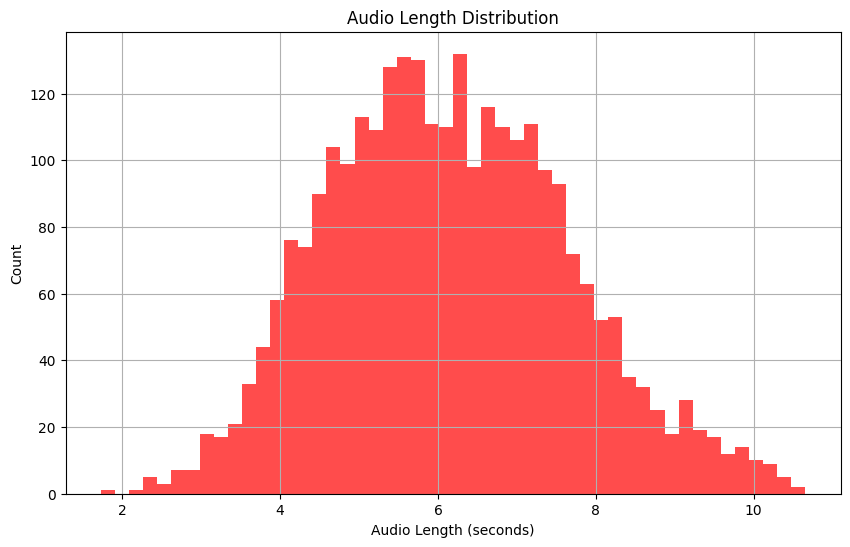

In [16]:
#visualizing audio length distribution

#converting milliseconds into seconds
validated_cleaned['audio_length_secs'] = validated_cleaned['audio_length'] / 1000

#plotting the graph
plt.figure(figsize=(10, 6))
plt.hist(validated_cleaned['audio_length_secs'], bins=50, alpha=0.7, color='r')
plt.title('Audio Length Distribution')
plt.xlabel('Audio Length (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

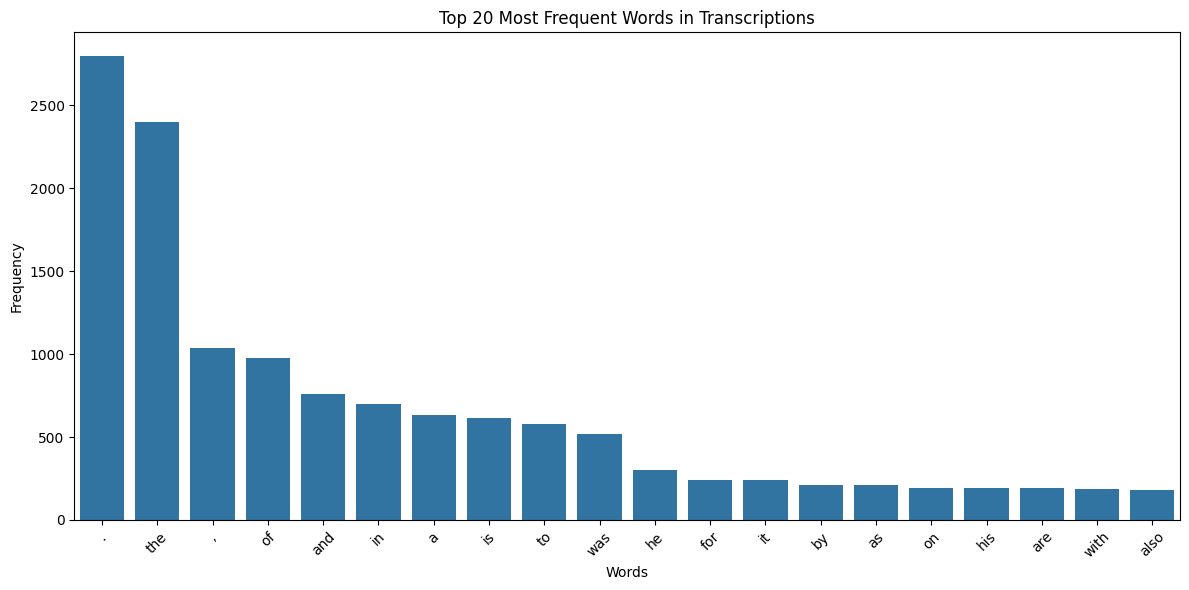

In [17]:
#tokenizing and counting frequency
words = []
for sentence in validated_cleaned['sentence']:
    tokens = word_tokenize(sentence)
    words.extend(tokens)

word_freq = Counter(words)

#converting into a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])

#sorting
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

#plotting the graph
plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='frequency', data=word_freq_df.head(20))
plt.title('Top 20 Most Frequent Words in Transcriptions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


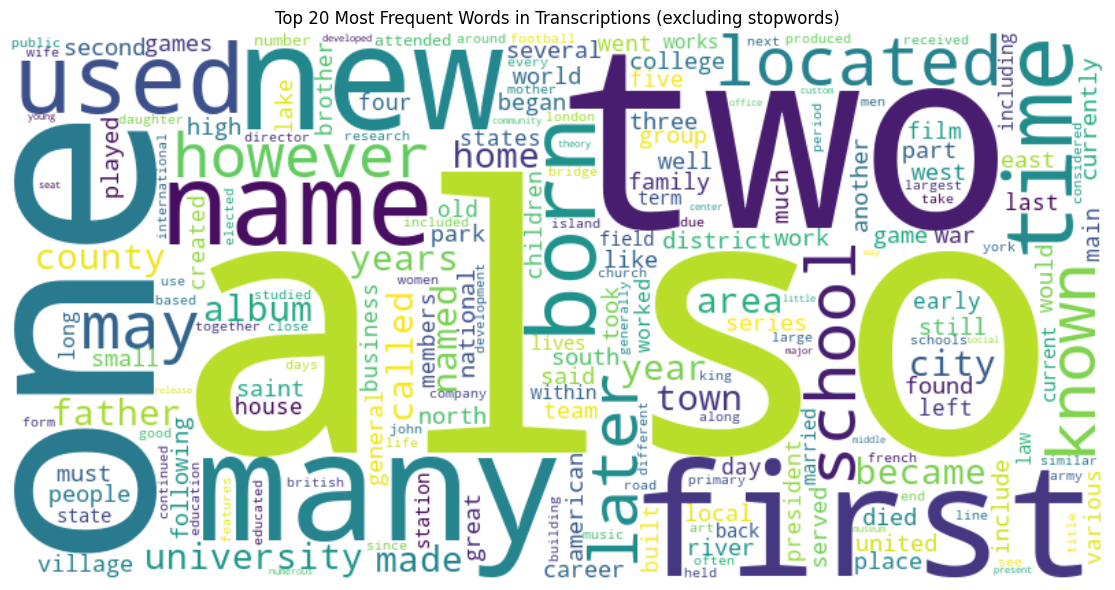

In [32]:
#downloading stopwords
nltk.download('stopwords')

#tokenizing and counting frequency
words = []

#adding stopwords (English)
stop_words = set(stopwords.words('english'))  
for sentence in validated_cleaned['sentence']:
    tokens = word_tokenize(sentence)
    words.extend([word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words])

word_freq = Counter(words)

#converting into a DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])

#sorting
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

#plotting a wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top 20 Most Frequent Words in Transcriptions (excluding stopwords)')
plt.axis('off')
plt.tight_layout()
plt.show()

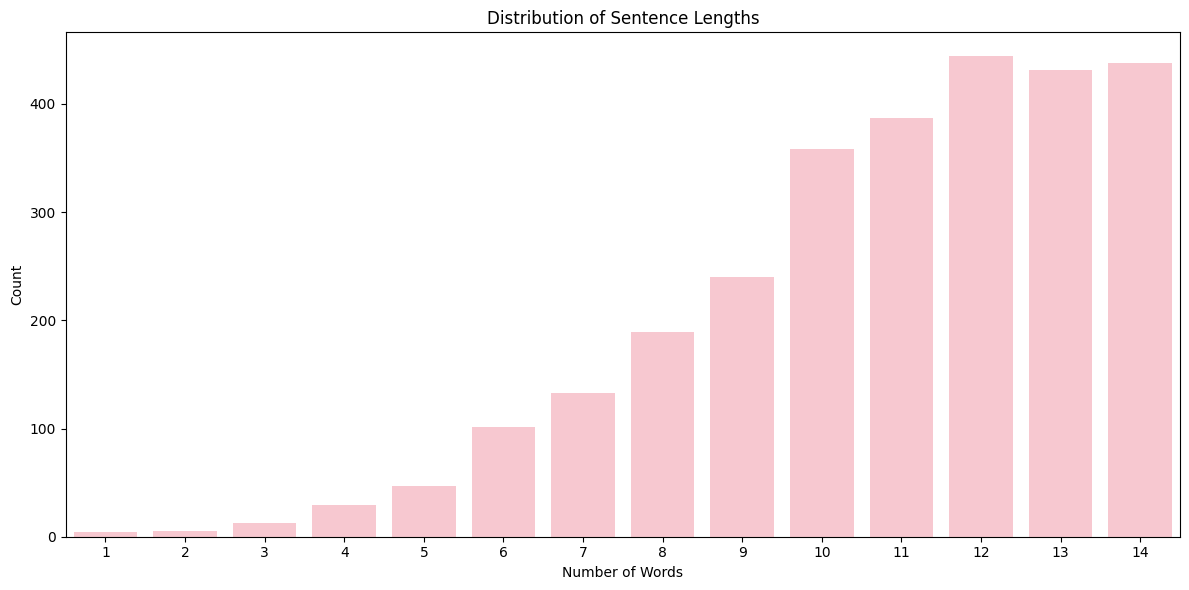

In [19]:
#distribution of sentences lengths by word count
sentence_lengths = validated_cleaned['sentence'].apply(lambda x: len(x.split()))

length_counts = sentence_lengths.value_counts().sort_index()

#plotting the graph
plt.figure(figsize=(12, 6))
sns.barplot(x=length_counts.index, y=length_counts.values, color='pink')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

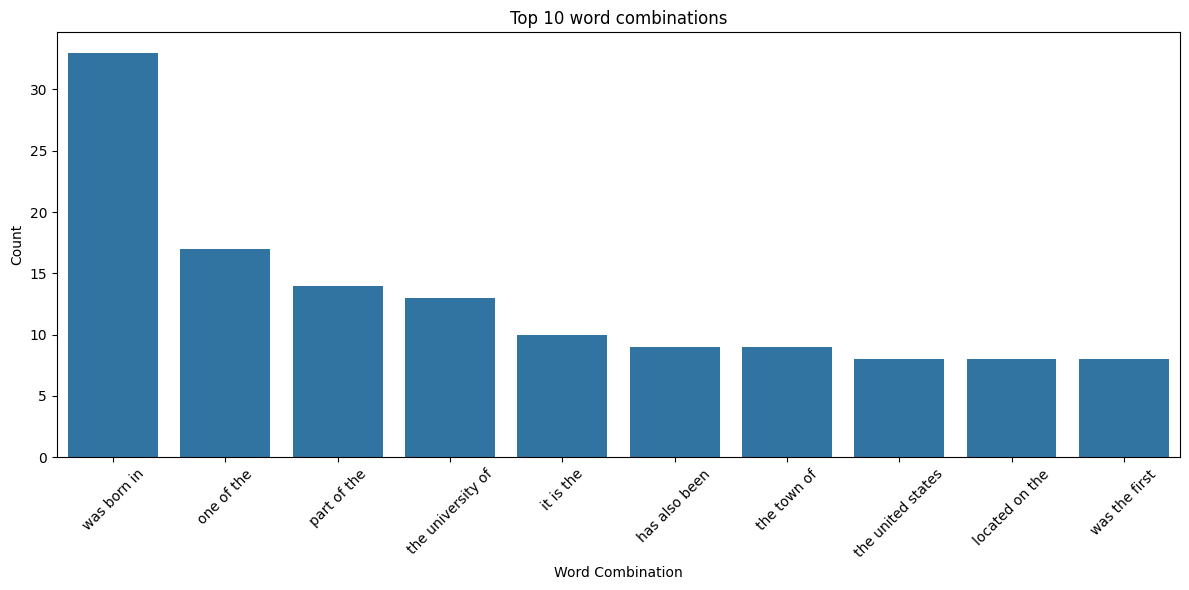

In [20]:
#getting most used word combinations
def get_top_ngrams(corpus, ngram_range=(3, 3), top=10):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

top_trigrams = get_top_ngrams(validated_cleaned['sentence'], ngram_range=(3, 3), top=10)

#plotting the graph
plt.figure(figsize=(12, 6))
sns.barplot(x=[trigram[0] for trigram in top_trigrams], y=[trigram[1] for trigram in top_trigrams])
plt.title('Top 10 word combinations')
plt.xlabel('Word Combination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

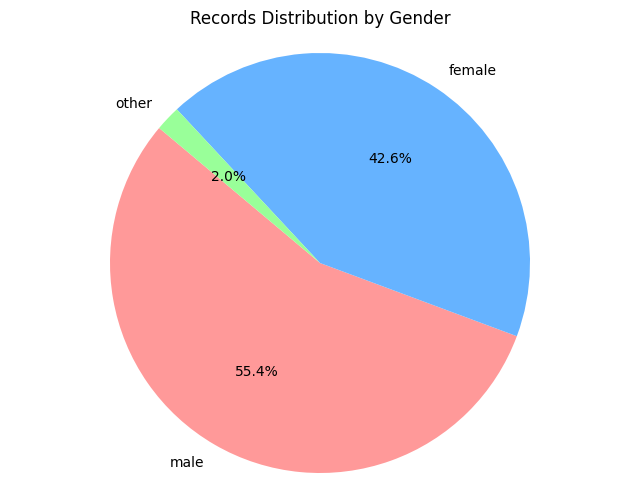

In [33]:
#frequency distribution by gender
gender_counts = validated_cleaned['gender'].value_counts()

#plotting the graph
plt.figure(figsize=(8, 6))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Records Distribution by Gender')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

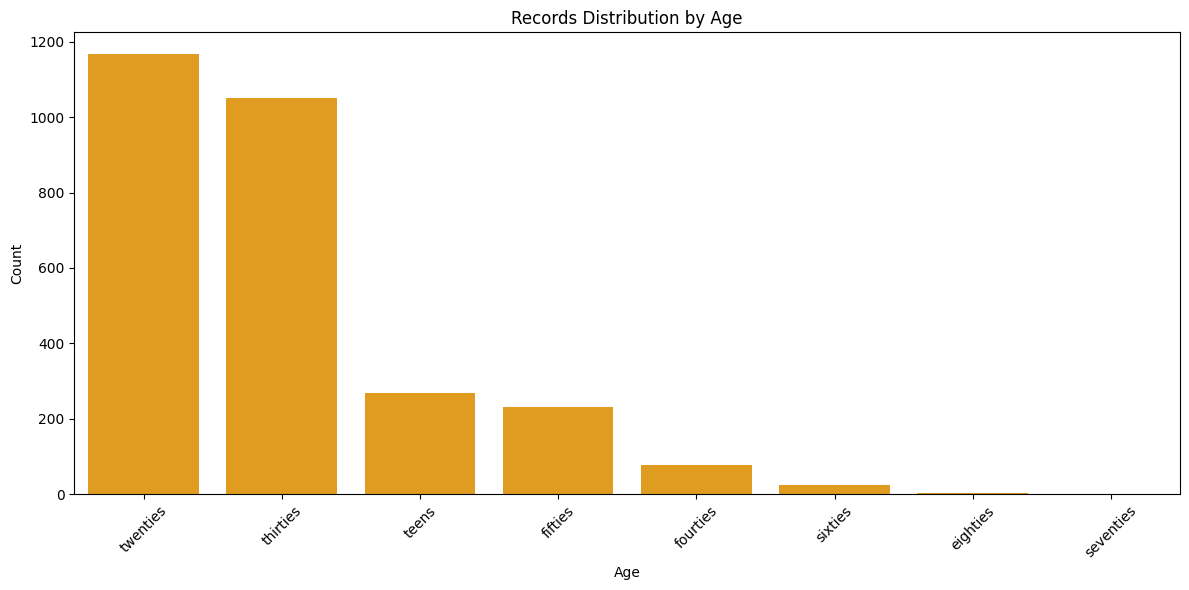

In [22]:
#frequency distribution by age
age_counts = validated_cleaned['age'].value_counts()

#plotting the graph
plt.figure(figsize=(12, 6))
sns.barplot(x=age_counts.index, y=age_counts.values, color='orange')
plt.title('Records Distribution by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

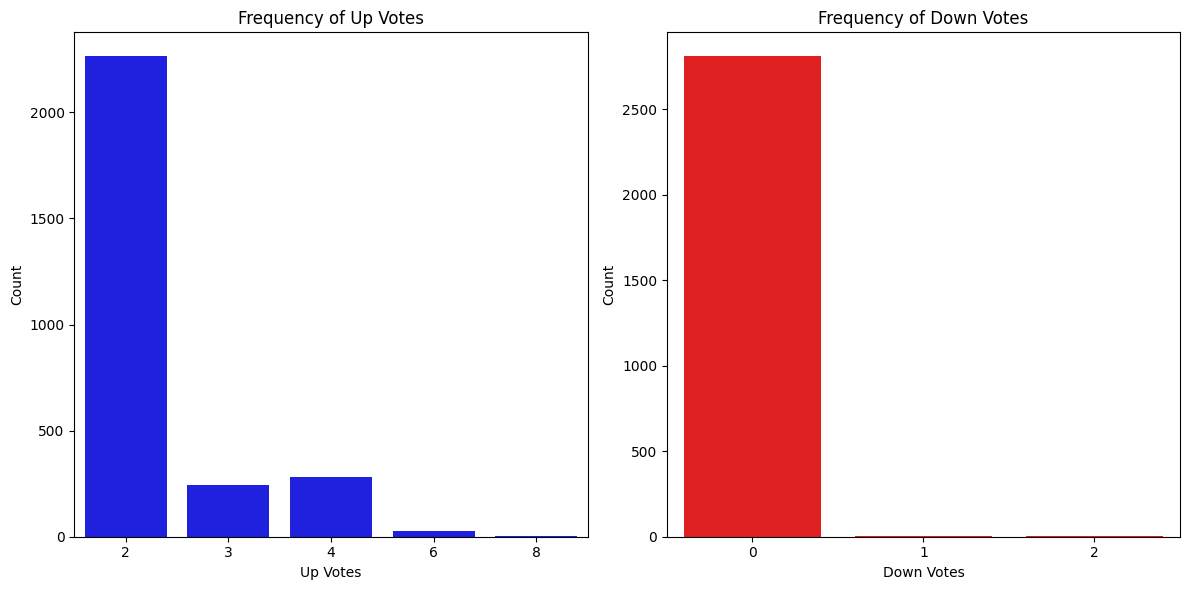

In [23]:
#frequency distribution by up and down votes
up_votes_counts = validated_cleaned['up_votes'].value_counts()
down_votes_counts = validated_cleaned['down_votes'].value_counts()

#plotting the graph
plt.figure(figsize=(12, 6))

#barplot for up_votes
plt.subplot(1, 2, 1)
sns.barplot(x=up_votes_counts.index, y=up_votes_counts.values, color='blue')
plt.title('Frequency of Up Votes')
plt.xlabel('Up Votes')
plt.ylabel('Count')

#barplot for down_votes
plt.subplot(1, 2, 2)
sns.barplot(x=down_votes_counts.index, y=down_votes_counts.values, color='red')
plt.title('Frequency of Down Votes')
plt.xlabel('Down Votes')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

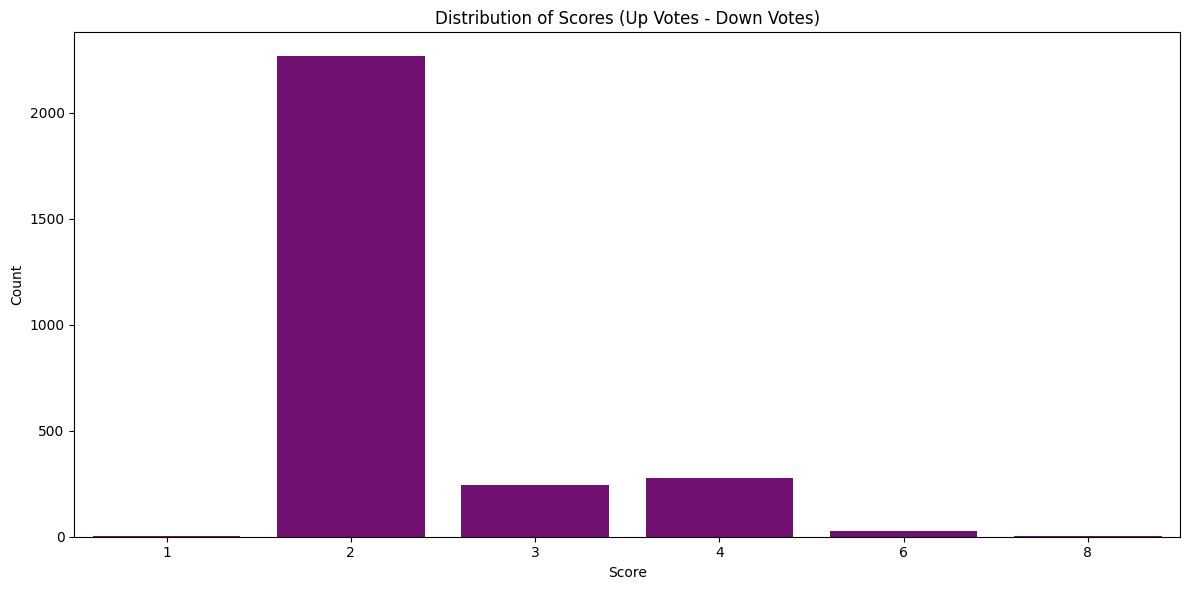

In [24]:
##frequency distribution by score (up_votes - down_votes)
validated_cleaned['score'] = validated_cleaned['up_votes'] - validated_cleaned['down_votes']

#plotting the graph
plt.figure(figsize=(12, 6))
sns.barplot(x=validated_cleaned['score'].value_counts().index, 
            y=validated_cleaned['score'].value_counts().values, 
            color='purple')
plt.title('Distribution of Scores (Up Votes - Down Votes)')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [25]:
#counting unique types of accents
accent_count = validated_cleaned['accents'].nunique()

print(f'Audios are recorded with {accent_count} different accents.')

Audios are recorded with 38 different accents.


In [26]:
#top 10 accents with their most scores
accent_counts = validated_cleaned['accents'].value_counts()

accent_counts.head(10)

accents
Southern African (South Africa, Zimbabwe, Namibia)                                                                            1469
Canadian English                                                                                                               392
United States English                                                                                                          218
South African accent ,Southern African (South Africa, Zimbabwe, Namibia)                                                       171
My accent is influenced by the phones of all letters within a sentence.,Southern African (South Africa, Zimbabwe, Namibia)     134
German English,Non native speaker                                                                                              134
Irish English                                                                                                                   48
United States English,Speech impediment,Rhotacism                          

# Data Preprocessing

In [27]:
#feature extracting function
def extract_features(file_paths):
    features = []
    for path in file_paths:
        #loading audios
        audio, sr = librosa.load(path, sr=None)
        
        #extracting MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        
        #calculating mean
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        #appenting to the list
        features.append(mfccs_mean)
    
    return np.array(features)

In [28]:
#applying feature extraction
file_paths = ['en/clips/' + clip for clip in validated_cleaned['clip']]
labels = validated_cleaned['gender'] 

#extracting features
X = extract_features(file_paths)

#encoding the labels
le = LabelEncoder()
y = le.fit_transform(labels)

#saving features and labels
np.save('mfcc_features.npy', X)
np.save('labels.npy', y)

In [29]:
#splitting into train, validation and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=3)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=3)

#checking for the size
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2255
Validation set size: 282
Test set size: 282


# Additional: Model Training

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_classes = len(np.unique(y_train))

#reshaping into needed format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#model defining
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

#model compiling
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model traning
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val))

#model evaluating
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6872 - loss: 0.7518 - val_accuracy: 0.7482 - val_loss: 0.5521
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7617 - loss: 0.5838 - val_accuracy: 0.7801 - val_loss: 0.4959
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7951 - loss: 0.4897 - val_accuracy: 0.8121 - val_loss: 0.4731
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8249 - loss: 0.4595 - val_accuracy: 0.8333 - val_loss: 0.4084
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8123 - loss: 0.4613 - val_accuracy: 0.8688 - val_loss: 0.3907
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8486 - loss: 0.3966 - val_accuracy: 0.8617 - val_loss: 0.3816
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8529 - loss: 0.3820 - val_accuracy: 0.8723 - val_loss: 0.3283
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8648 - loss: 0.3492 - val_accuracy: 0.8865 - val_loss

# Documentation

- Data Collection:
    - I used Common Voice Delta Segment 15.0 (English) (48 validated hours) dataset from Mozilla due to its smaller size

- Data Cleaning:
    - Firstly, I have checked for NA values and dropped 2 columns which has no data (only NA values)
    - Secondly, I have dropped the rows with NA values in age, gender, accents columns instead of replacing them with some value to avoid later inaccuracy while model traning. (I used a small data and filling NA values with inaccurate data, especially, age and gender may not be a good idea)
    - Lastly, I normalized the data in the 'sentence' column (transcripts) by removing extra whitespaces, special characters and converting into lowercase. (I decided to leave commas and fullstops, as in audios, it is noticeable where there should be a punctuation)

- Exploratory Data Analysis:
    - I merged another table where there were lengths of audios and visualized audio lengths distribution
    - By using NLTK library, I visualized top 20 words in the transcripts (with and without sropwords)
    - Other visualizations: frequency distribution graphs, top combinations of words and etc.

- Data Preprocessing:
    - I used MFCCs to extract features from the audio files
    - Splitted dataset into train, validation and test sets (80%, 10%, 10%)

- Additional:
    - Trained a RNN model and evaluated on validation and test sets (got ~93% accuracy on both)